In [1]:
%pwd

'/home/acr/Documents/Projeto Sistemas Mecatrónicos/RL-SistMecatron/Resultados e Código para Relatório'

# Only runs on Python 3.7 because of the stableBaselines

# Building our own scenario

Build a reinforcement learning model to adjust the temperature automatically to get in the optimal range

Optimal temperature: Between 37 and 39 degrees
Shower Length: 60 seconds
Actions: Turn down, Leave, Turn up
Task: Build a model that keeps us in the optimal range for as long as possible

# Install Dependencies

In [33]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2
!pip install tensorflow-gpu==2.3.0 
!pip install stable_baselines 
!pip install gym
!conda install swig -y # needed to build Box2D in the pip install
!pip install box2d-py # a repackaged version of pybox2d

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.7.0rc0, 2.7.0rc1, 2.7.0)
ERROR: No matching distribution found for tensorflow==2.3.0


# Creating a random environment

#### The goal is to balance the pole up, moving the cart to the left or right . For each step it takes a point, for a maximum of 200 points

In [1]:
from gym import Env # Allows us to build our environment on top of it
from gym import spaces
from gym.spaces import Discrete, Box # Allows us to define the actions and the states of our environment
import numpy as np
import random
import time
import matplotlib.pyplot as plt

/home/acr/anaconda3/envs/p37workshop/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
class ShowerEnv(Env): # By passing Env to the showerEnv class we are inheriting the methods and properties from the OpenAI gym environment class
    metadata = {'render.modes': ['console']}
    
    def __init__(self): # We will be initializing the actions we can take, our observation space, the space, the temperature and the shower length 
        super(ShowerEnv,self).__init__()
        # Actions we can take, down, stay, up
        self.action_space=spaces.Discrete(3)
        # Temperature array
        self.observation_space = Box(low=0, high=100, shape=(1,), dtype=np.float32) # Box allows to gave a whole range of spaces
        # Set start temp (As in real life, the shower's water starts cold)
        self.state = 15 + random.randint(-3,3)
        # Set shower length
        self.shower_length = 60*5 # 10 minutes=10*60 seconds

    def reset(self):
        # Reset shower temperature
        self.state = 15 +random.randint(-3,3)
        # Reset shower time
        self.shower_length = 60*5
        return np.array([self.state]).astype(np.float32)
    
    def step(self, action): # Defines what we do whenever we take actions
        # Aplly action
        # As the action is 0,1 or 2, as we subtract 1 when temperature decreases is -1, when it stays the same is 0 and when it increases is +1
        # 0-1=-1, 1-1=0, 2-1=1
        self.state += action -1
        # Reduce shower length by 1 second
        self.shower_length -= 1
        
        #Calculate reward
        # If water is 38 it gives a reward of 2, if it is 37 or 29 it gives a reward of 1
        if self.state>= 37 and self.state<=39:
            reward= (2-abs(38-self.state))*6
        # The negative rewards will be greater if the colder the water is and the hotter the water is 
        elif self.state < 37:
            reward=-(37-self.state)*2
        elif self.state > 39:
            reward = -(self.state-39)*2
        
        # Check if shower is done
        if self.shower_length <=0 :
            done = True
        else:
            done = False                
        
        # Apply temperature noise
#         self.state+=random.randint(-2,2)
        # Set placeholder for info
        info= {}
        
        # Return step information
        return np.array([self.state]).astype(np.float32), reward, done, info # self.state is the temperature
    
    def render(self): # Visualizations
        # Implement visualization
        pass
    
    def close(self):
        pass

In [3]:
env = ShowerEnv()

In [4]:
env.step(1)[0]

array([13.], dtype=float32)

In [5]:
env.action_space.sample()

0

In [6]:
env.observation_space.high[0]

100.0

In [7]:
env.observation_space.sample()

array([63.971043], dtype=float32)

#### Now we're just setting some random episodes where there is no learning from each of the episodes

Box([0.], [100.], (1,), float32)
Discrete(3)
1

Episode:1 Score: -5238 
Episode:2 Score: -17006 
Episode:3 Score: -8436 
Episode:4 Score: -7862 
Episode:5 Score: -20316 
Episode:6 Score: -11776 
Episode:7 Score: -15966 
Episode:8 Score: -9140 
Episode:9 Score: -7810 
Episode:10 Score: -7428 


<function matplotlib.pyplot.show(close=None, block=None)>

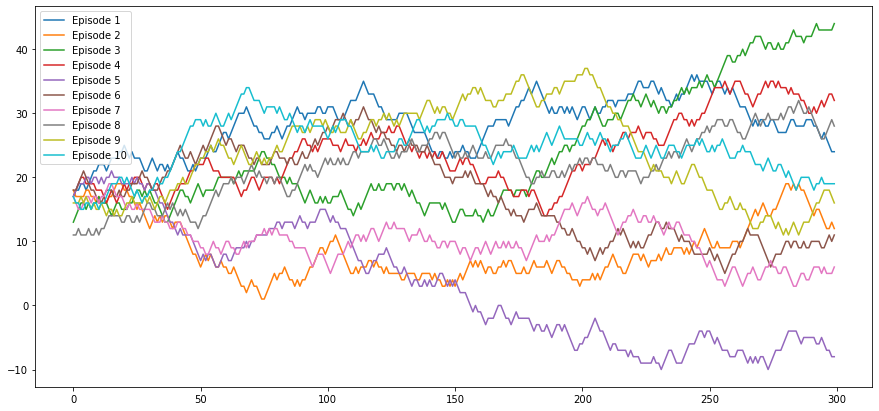

In [8]:
obs = env.reset()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())
print()

plt.figure(figsize=(15,7))
episodes = 10
for episode in range(1,episodes+1):
  state=env.reset()
  done=False
  score=0
  Temp_plot=[]

  while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    Temp_plot.append(obs)
    score+=reward
    info = info
    
  plt.plot(Temp_plot, label = 'Episode {}'.format(episode))
  plt.legend()
  print('Episode:{} Score: {} '.format(episode, round(score,0)))
plt.show

# Build Agent with StableBaselines

In [9]:
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.cmd_util import make_vec_env

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/acr/anaconda3/envs/p37workshop/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


Checking if the environment follows the gym interface

In [10]:
# It will check your custom environment and output additional warnings if needed
check_env(env, warn=True)

In [11]:
env = make_vec_env(lambda: env, n_envs=1)

In [12]:
model1 = DQN('MlpPolicy', env, verbose=1).learn(15000)







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











State: None
Action:  1
State 17.0 reward= -40.0 done= [False]
Sum of rewards: -40.0
Step: 1

State: None
Action:  1
State 18.0 reward= -38.0 done= [False]
Sum of rewards: -78.0
Step: 2

State: None
Action:  1
State 19.0 reward= -36.0 done= [False]
Sum of rewards: -114.0
Step: 3

State: None
Action:  1
State 20.0 reward= -34.0 done= [False]
Sum of rewards: -148.0
Step: 4

State: None
Action:  1
State 21.0 reward= -32.0 done= [False]
Sum of rewards: -180.0
Step: 5

State: None
Action:  1
State 22.0 reward= -30.0 done= [False]
Sum of rewards: -210.0
Step: 6

State: None
Action:  1
State 23.0 reward= -28.0 done= [False]
Sum of rewards: -238.0
Step: 7

State: None
Action:  1
State 24.0 reward= -26.0 done= [False]
Sum of rewards: -264.0
Step: 8

State: None
Action:  1
State 25.0 reward= -24.0 done= [False]
Sum of rewards: -288.0
Step: 9

State: None
Action:  1
State 26.0 reward= -22.0 done= [False]
Sum of rewards: -310.0
Step: 10

State: None
Action:  1
State 27.0 reward= -20.0 done= [False


State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -910.0
Step: 142

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -914.0
Step: 143

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -918.0
Step: 144

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -922.0
Step: 145

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -926.0
Step: 146

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -930.0
Step: 147

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -934.0
Step: 148

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -938.0
Step: 149

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -942.0
Step: 150

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -946.0
Step: 151

State: None
Action:  0
State 35.0 reward= -4.0 do


State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -1254.0
Step: 228

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -1258.0
Step: 229

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -1262.0
Step: 230

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -1266.0
Step: 231

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -1270.0
Step: 232

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -1274.0
Step: 233

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -1278.0
Step: 234

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -1282.0
Step: 235

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -1286.0
Step: 236

State: None
Action:  0
State 35.0 reward= -4.0 done= [False]
Sum of rewards: -1290.0
Step: 237

State: None
Action:  0
State 35.0 rewar

<function matplotlib.pyplot.show(close=None, block=None)>

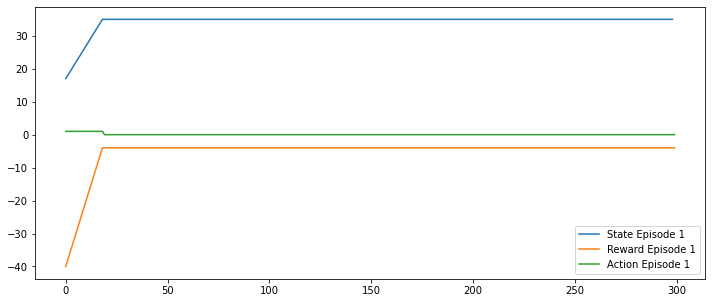

In [13]:
episodes =1
for episode in range(1,episodes+1):
  obs=env.reset()
  done=False
  state_batch = []
  reward_batch = []
  action_batch = []
  total_rewards = 0
  total_rewards_list= []
  step = 0
    
  while not done:
    step+=1
    action, obs = model1.predict(obs)
    print('\nState:',obs)
    print("Action: ", action[0]-1)
    action_batch.append(action-1)
    obs, rewards, done, info = env.step(action)
    print('State', obs[0][0], 'reward=', rewards[0], 'done=', done)
    state_batch.append(obs[0][0])
    reward_batch.append(rewards)
    total_rewards += rewards
    total_rewards_list.append(total_rewards[0])
    print('Sum of rewards:', total_rewards[0])
    print('Step:', step)

  plt.figure(figsize=(12,5))  
  plt.plot(state_batch[:-1], label='State Episode {}'.format(episode))
  plt.plot(reward_batch,label='Reward Episode {}'.format(episode))
  plt.plot(action_batch, label='Action Episode {}'.format(episode))
#   plt.plot(total_rewards_list, label='Sum of rewards Episode {}'.format(episode))
  plt.legend()
plt.show

In [14]:
# model2 = DQN('MlpPolicy', env, verbose=1).learn(120000)

In [15]:
model2 = DQN.load("DQN_NoNoise_Baselines_model_120kSteps", env=env)

In [16]:
episodes =100
Reward_per_Episode = []
for episode in range(1,episodes+1):
  obs=env.reset()
  done=False
  state_batch = []
  reward_batch = []
  action_batch = []
  total_rewards = 0
  total_rewards_list= []
  step = 0
    
  while not done:
    step+=1
    action, obs = model2.predict(obs)
#     print('\nState:',obs)
#     print("Action: ", action[0]-1)
    action_batch.append(action-1)
    obs, rewards, done, info = env.step(action)
#     print('State', obs[0][0], 'reward=', rewards[0], 'done=', done)
    state_batch.append(obs[0][0])
    reward_batch.append(rewards)
    total_rewards += rewards
    total_rewards_list.append(total_rewards[0])
#     print('Sum of rewards:', total_rewards[0])
#     print('Step:', step)
#   print(total_rewards)
  Reward_per_Episode.append(total_rewards)
  print('Episode: {} Reward: {} Steps: {}'.format(episode, Reward_per_Episode[episode-1][0], step))
print('\nAverage Episode Reward: {}'.format(np.mean(Reward_per_Episode)))

Episode: 1 Reward: 2766.0 Steps: 300
Episode: 2 Reward: 2766.0 Steps: 300
Episode: 3 Reward: 2706.0 Steps: 300
Episode: 4 Reward: 2824.0 Steps: 300
Episode: 5 Reward: 2824.0 Steps: 300
Episode: 6 Reward: 2766.0 Steps: 300
Episode: 7 Reward: 2706.0 Steps: 300
Episode: 8 Reward: 2824.0 Steps: 300
Episode: 9 Reward: 2880.0 Steps: 300
Episode: 10 Reward: 2934.0 Steps: 300
Episode: 11 Reward: 3036.0 Steps: 300
Episode: 12 Reward: 2986.0 Steps: 300
Episode: 13 Reward: 3036.0 Steps: 300
Episode: 14 Reward: 2880.0 Steps: 300
Episode: 15 Reward: 2934.0 Steps: 300
Episode: 16 Reward: 3036.0 Steps: 300
Episode: 17 Reward: 3036.0 Steps: 300
Episode: 18 Reward: 3036.0 Steps: 300
Episode: 19 Reward: 2824.0 Steps: 300
Episode: 20 Reward: 2934.0 Steps: 300
Episode: 21 Reward: 3036.0 Steps: 300
Episode: 22 Reward: 2934.0 Steps: 300
Episode: 23 Reward: 3036.0 Steps: 300
Episode: 24 Reward: 3036.0 Steps: 300
Episode: 25 Reward: 3036.0 Steps: 300
Episode: 26 Reward: 2766.0 Steps: 300
Episode: 27 Reward: 2


State: None
Action:  1
State 14.0 reward= -46.0 done= [False]
Sum of rewards: -46.0
Step: 1

State: None
Action:  1
State 15.0 reward= -44.0 done= [False]
Sum of rewards: -90.0
Step: 2

State: None
Action:  1
State 16.0 reward= -42.0 done= [False]
Sum of rewards: -132.0
Step: 3

State: None
Action:  1
State 17.0 reward= -40.0 done= [False]
Sum of rewards: -172.0
Step: 4

State: None
Action:  1
State 18.0 reward= -38.0 done= [False]
Sum of rewards: -210.0
Step: 5

State: None
Action:  1
State 19.0 reward= -36.0 done= [False]
Sum of rewards: -246.0
Step: 6

State: None
Action:  1
State 20.0 reward= -34.0 done= [False]
Sum of rewards: -280.0
Step: 7

State: None
Action:  1
State 21.0 reward= -32.0 done= [False]
Sum of rewards: -312.0
Step: 8

State: None
Action:  1
State 22.0 reward= -30.0 done= [False]
Sum of rewards: -342.0
Step: 9

State: None
Action:  1
State 23.0 reward= -28.0 done= [False]
Sum of rewards: -370.0
Step: 10

State: None
Action:  1
State 24.0 reward= -26.0 done= [False


State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 942.0
Step: 148

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 954.0
Step: 149

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 966.0
Step: 150

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 978.0
Step: 151

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 990.0
Step: 152

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1002.0
Step: 153

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1014.0
Step: 154

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1026.0
Step: 155

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1038.0
Step: 156

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1050.0
Step: 157

State: None
Action:  0
State 38.0 reward= 12.0 done= [

<function matplotlib.pyplot.show(close=None, block=None)>

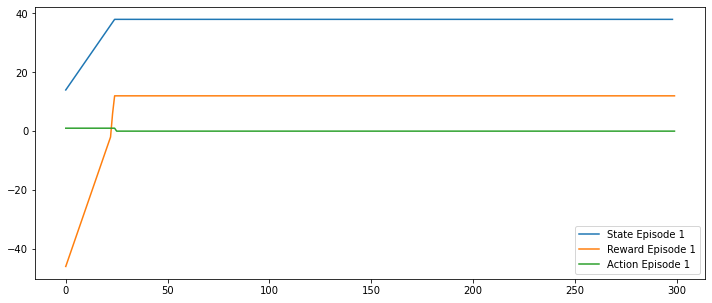

In [17]:
plt.figure(figsize=(12,5))  

episodes =1
for episode in range(1,episodes+1):
  obs=env.reset()
  done=False
  state_batch = []
  reward_batch = []
  action_batch = []
  total_rewards = 0
  total_rewards_list= []
  step = 0
    
  while not done:
    step+=1
    action, obs = model2.predict(obs)
    print('\nState:',obs)
    print("Action: ", action[0]-1)
    action_batch.append(action-1)
    obs, rewards, done, info = env.step(action)
    print('State', obs[0][0], 'reward=', rewards[0], 'done=', done)
    state_batch.append(obs[0][0])
    reward_batch.append(rewards)
    total_rewards += rewards
    total_rewards_list.append(total_rewards[0])
    print('Sum of rewards:', total_rewards[0])
    print('Step:', step)

  plt.plot(state_batch[:-1], label='State Episode {}'.format(episode))
  plt.plot(reward_batch,label='Reward Episode {}'.format(episode))
  plt.plot(action_batch, label='Action Episode {}'.format(episode))
#   plt.plot(total_rewards_list, label='Sum of rewards Episode {}'.format(episode))
  plt.legend()
plt.show